In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv, SAGEConv
from tqdm import tqdm
import torch.optim as optim
import json

In [2]:
os.getcwd()
use_cuda_if_available = False
BATCH_SIZE = 50
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    
seed = 956087
set_seed(seed)

# Importing the Main tabular data

In [6]:
with open('signal_btagged_2j1p.json', 'r') as file:
    signal = json.load(file)

with open('background_btagged_2j1p.json', 'r') as file:
    background = json.load(file)

In [7]:
print(signal[0])
print()
print(background[0])

{'nodes': [[0.214053, 2.49454, 37.8202, 38.6899], [-0.0143928, -0.208869, 28.6807, 28.6837], [-0.115036, -1.73382, 23.2269, 23.3808]], 'edges': [2.713043992422283, 2.0810109593528523, 1.5282684993505689], 'edge_index': [[0, 0, 1], [1, 2, 2]], 'node_labels': [0, 1, 1], 'jetmultiplicity': 2, 'inv_mass': 90.21762513276815, 'label': 1}

{'nodes': [[1.13126, -0.431804, 19.0611, 32.6154], [1.11429, 0.962557, 51.6036, 87.0954], [1.74965, -1.97337, 50.5056, 149.659]], 'edges': [1.394464262439522, 1.6609731859533434, 3.0038890923149943], 'edge_index': [[0, 0, 1], [1, 2, 2]], 'node_labels': [0, 1, 1], 'jetmultiplicity': 2, 'inv_mass': 123.59113817850537, 'label': 0}


# Plan for defining the Graph

Individual Event -> Graph -> Fully Connected Graph, Undirectional

Objects(Isophoton, jet1, jet2) -> Nodes

Node Lable -> (isophoton, jet1, jet2) -> (0,1,2)

Node Features -> (Eta, Phi, pT, E)

Edge Index -> ((0, 1, 2),(1, 2, 0))

Edge Features -> $\Delta R$ between the ((0,1), (1,2), (2,0))

Graph Features -> (jet_multiplicity, inv_mass)

Graph Lable -> 0:Background, 1:Signal

# Aggregating Node Features

In [10]:
def convert_to_pyg_graph(graph, graph_label):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass' for a single event.
    label : int
        The label of the event (1 for signal, 0 for background).

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)  # Shape: (3, num_features)
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.float).view(-1,1)
    
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['jetmultiplicity'],
                                         graph['inv_mass'],
                                         np.array(graph['edges']).std(),
                                        graph['node_labels'].count(0)], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor([graph_label], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    data.count_isophoton = graph_level_features[0, 3]
    data.node_label = node_labels 

    return data

def convert_all_to_pyg_graphs(graphs,  graph_label):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph,  graph_label)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completely successfully :)')
    return pyg_graphs

In [11]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal, 1)
background_pyg_graphs = convert_all_to_pyg_graphs(background, 0)

Initializing the process...


Progress: 100%|██████████| 886/886 [00:00<00:00, 2926.38it/s]


Process completely successfully :)
Initializing the process...


Progress: 100%|██████████| 1529/1529 [00:00<00:00, 11113.37it/s]

Process completely successfully :)


In [12]:
dataset = signal_pyg_graphs + background_pyg_graphs
dataset = random.sample(dataset, len(dataset))

In [13]:
dataset[2000]

Data(x=[3, 4], edge_index=[2, 3], edge_attr=[3, 1], y=[1], jet_multiplicity=2.0, inv_mass=122.8841781616211, proximity_spread=1.0919133424758911, count_isophoton=1.0, node_label=[3, 1])

# Train-Test Splits

In [14]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
len(train_loader)

34

In [16]:
len(dataset)

2415

# Graph Visualization

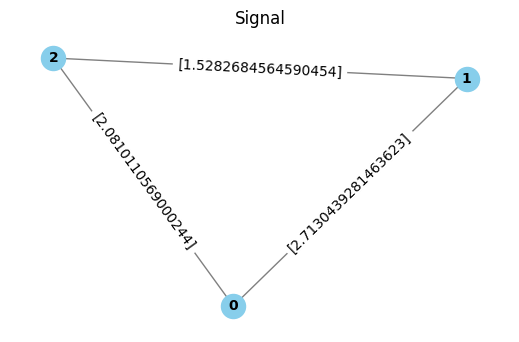

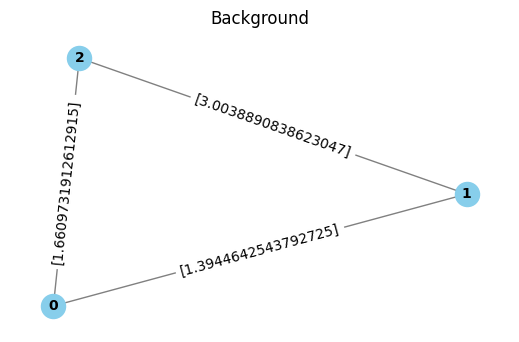

In [17]:
def visualize_graph(data, title):
    """
    Visualize a graph using networkx and matplotlib.
    
    Parameters:
    -----------
    data : Data
        A PyTorch Geometric Data object containing the graph to be visualized.
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])

    
    plt.figure(figsize=(5, 3))
    
    pos = nx.spring_layout(G)  # Layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title)
    plt.show()


visualize_graph(signal_pyg_graphs[0], 'Signal')
visualize_graph(background_pyg_graphs[0], 'Background')

## Model 4 Best

In [27]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features,*, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )
            
            self.graph_features_nn = torch.nn.Sequential(
            torch.nn.Linear(num_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, num_hidden_graph_features)
            )
            
        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )


        ############### Model 4 - Best
        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 128),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
             torch.nn.Linear(128, hidden_dim * hidden_dim)
        )
        
        # self.conv1 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # self.conv3 = CGConv((hidden_dim, hidden_dim), aggr = 'max')
        # self.conv4 = GMMConv(hidden_dim, hidden_dim, dim=1, kernel_size=5)
        # self.conv5 = GatedGraphConv(hidden_dim, 5, aggr = 'max')
        self.global_mean_pool_hook = global_mean_pool
        
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        # x = F.relu(self.conv3(x, edge_index, edge_attr))
        # x = F.relu(self.conv4(x, edge_index, edge_attr))
        # x = F.relu(self.conv5(x, edge_index, 1/edge_attr))
        
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)

        graph_features = torch.cat([data.inv_mass.view(-1, 1)], dim=1)
        x = torch.cat([x, graph_features], dim=1)
        self.graph_embedding = x
        # x = self.layerNorm(x)
        # Fully connected layers
        x = self.classify(x)
        x = torch.sigmoid(x) 

        return x


# Training and Evaluation Routines

In [28]:
def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation loop
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data).squeeze()
        pred = (out > 0.5).float()
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

## Network Training

In [29]:
model = GCNClassifier(num_node_features=4, num_edge_features = 1, hidden_dim=16, num_graph_features=1, num_hidden_graph_features = 0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad = False)
criterion = torch.nn.BCELoss()

EPOCHS = 250
training_loss = []
test_accuracy = []

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader)
        acc = test(model, test_loader)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s, Loss=0.5385, Accuracy=0.7738]


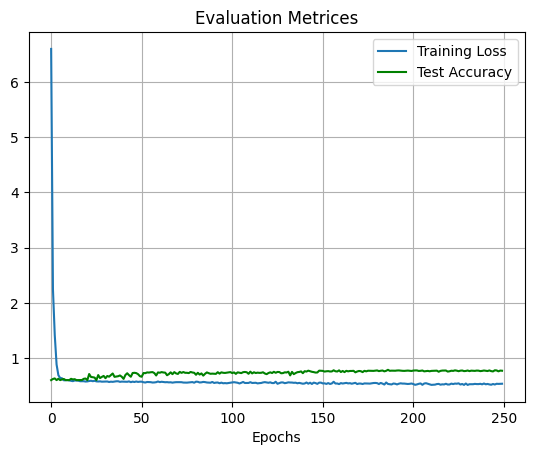

In [30]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Evaluation Metrices')
plt.xlabel('Epochs')
plt.grid(which = 'both')
#plt.savefig('94auc.png', dpi=200)
plt.show()

y_true = []
y_pred_prob = []
for _, graph in enumerate(dataset):
    y_true.append(graph.y.numpy()[0])
    out = model(graph).squeeze().detach().numpy()
    y_pred_prob.append(float(out))
y_true, y_pred_prob = np.array(y_true), np.array(y_pred_prob)
y_pred_labels = (y_pred_prob > 0.5)

LR+: 4.750
LR-: 0.390
Accuracy: 0.788
Precision: 0.733
Recall: 0.665
F1-Score: 0.697


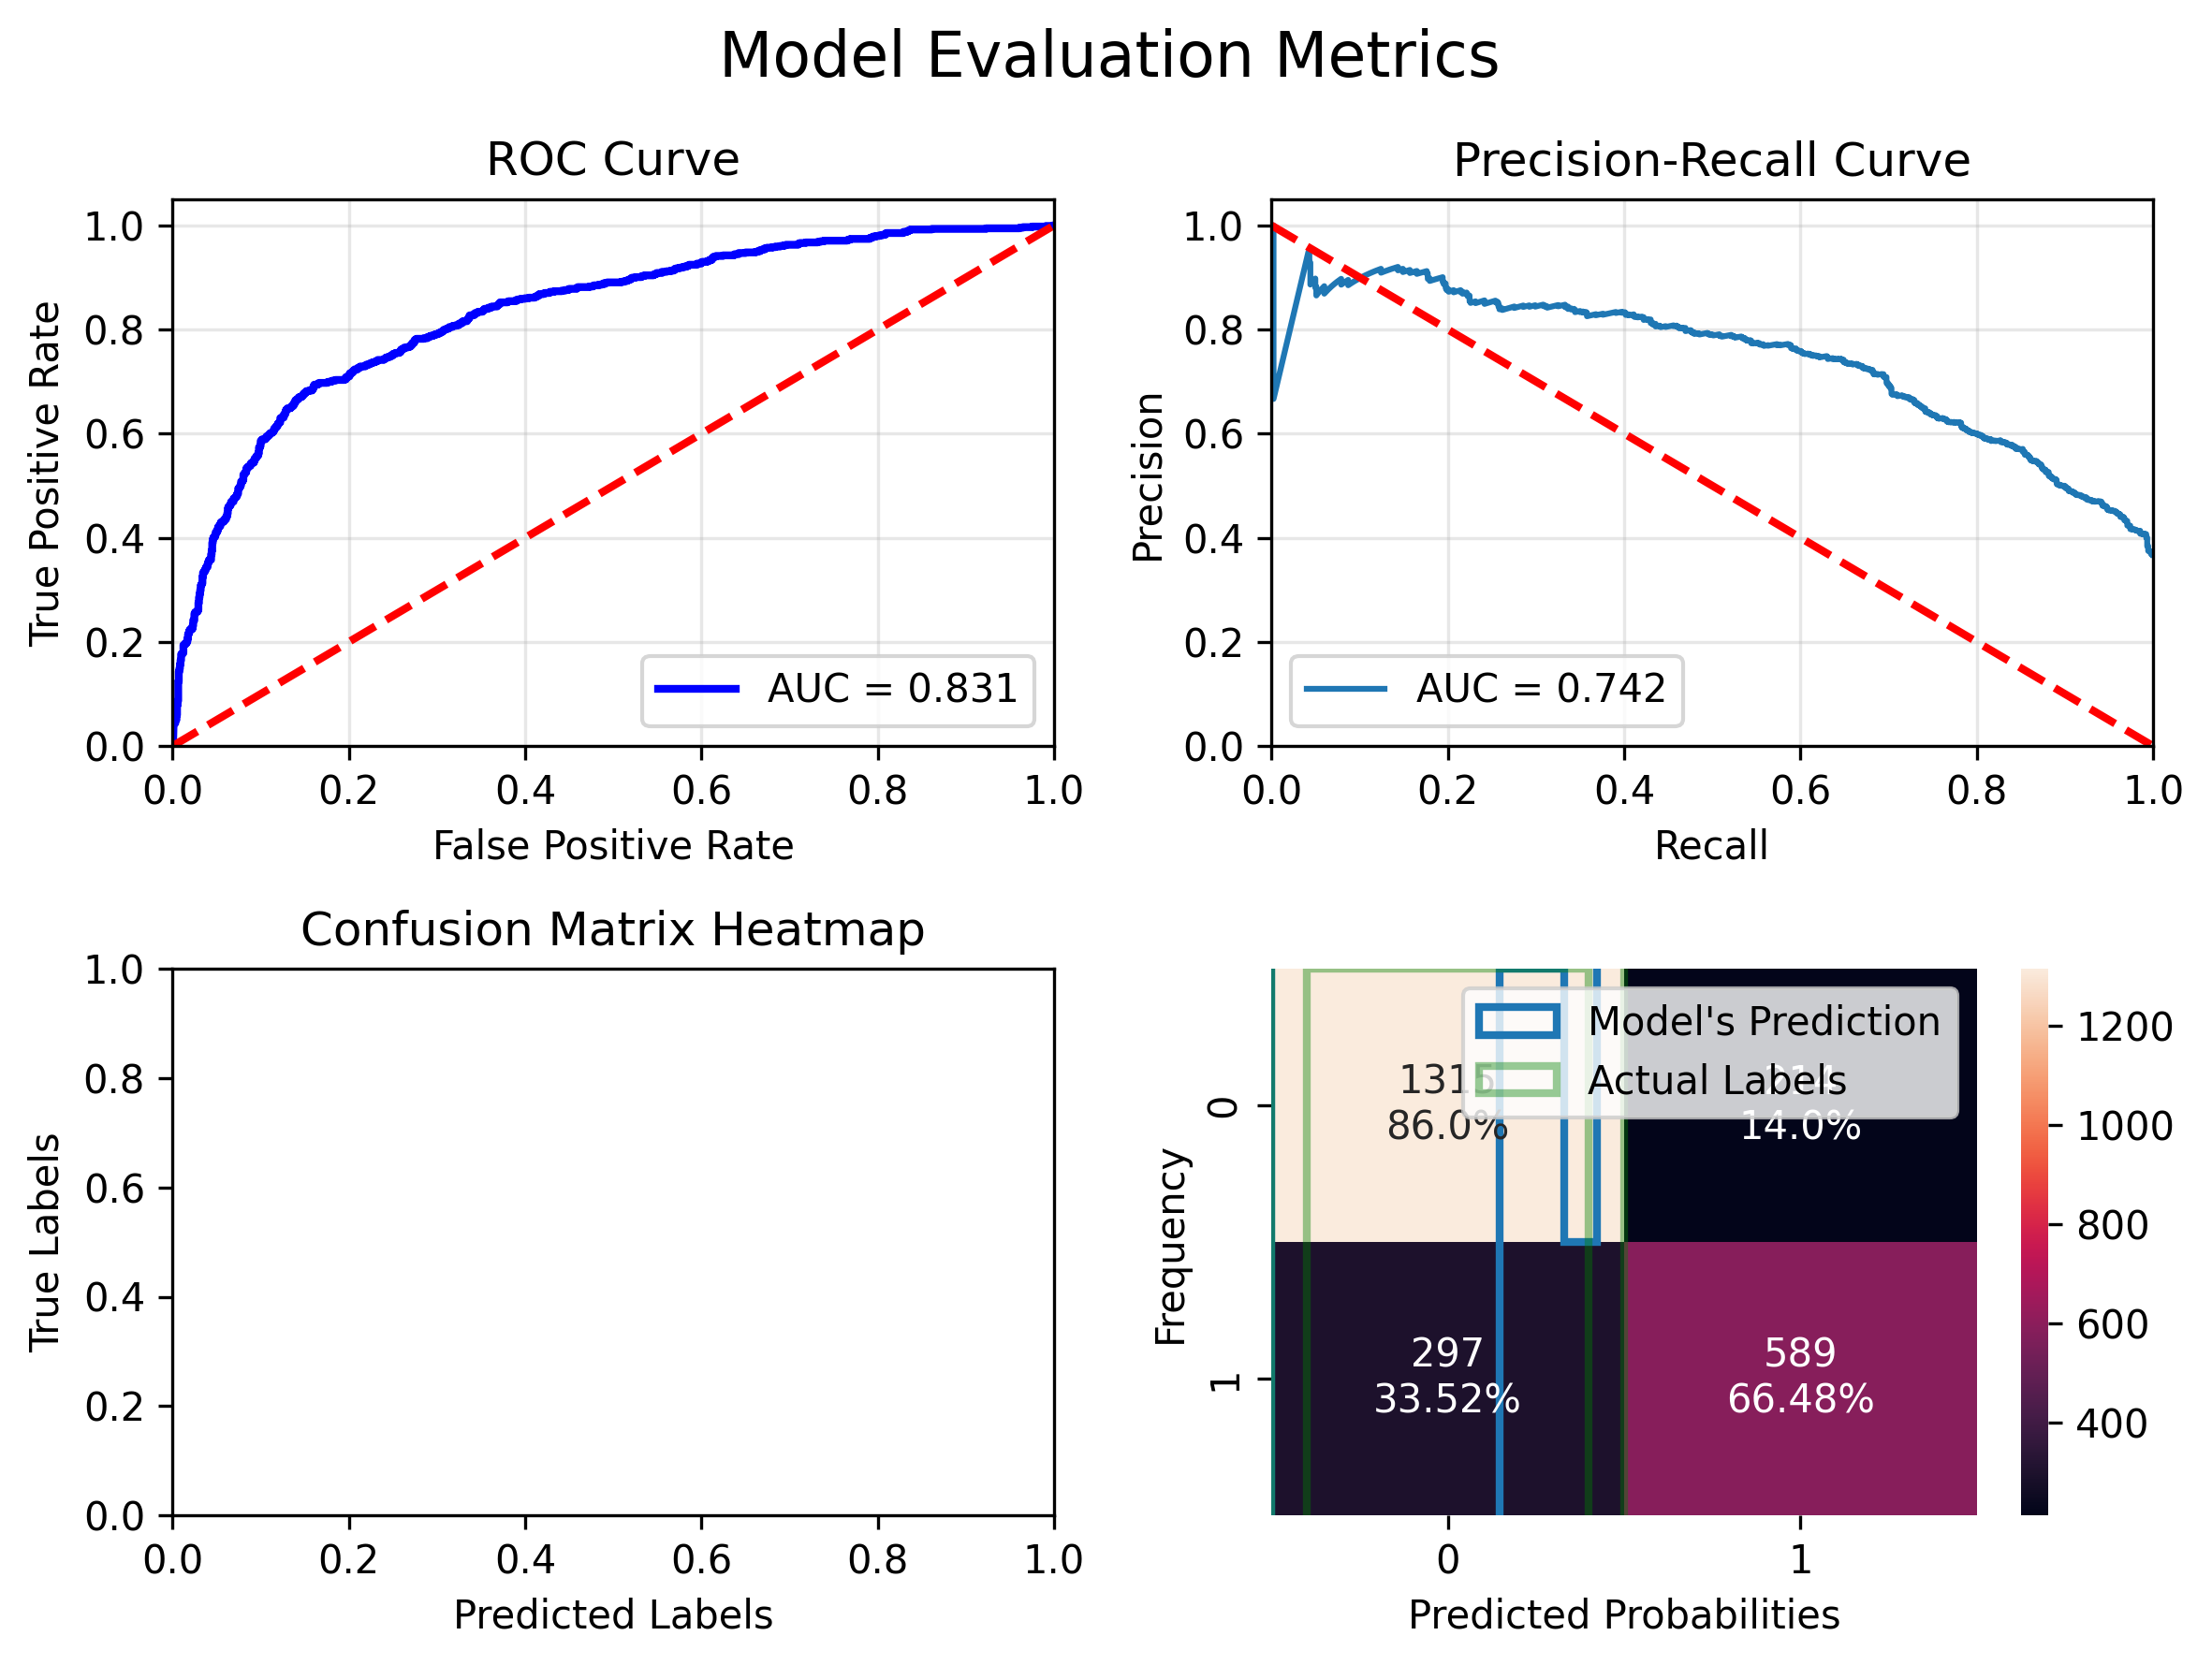

In [31]:
from helper_function_module import eval_model
eval_model(y_true, y_pred_prob, y_pred_labels)

In [ ]:
# np.save('NNConv_main_model', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'NNConv_main_model.pth')

# Extracting Graph Embedding from the Model

In [ ]:
# embedding_df = get_graph_embeddings()